In [54]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops_table
import pandas as pd
import napari
from napari.utils import nbscreenshot

## Random Composite Signal Generation

In [3]:
seed = 42
np.random.seed(seed)


n_samples = 500
freq = 5
time = np.linspace(0, 1, n_samples)

* Signal1: gaussian
* Signal2: Cardiac AP
* Signal3: Decreasing Monoexponential

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_14748\3660883483.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  signal1 = signal.gaussian(30, std=3)


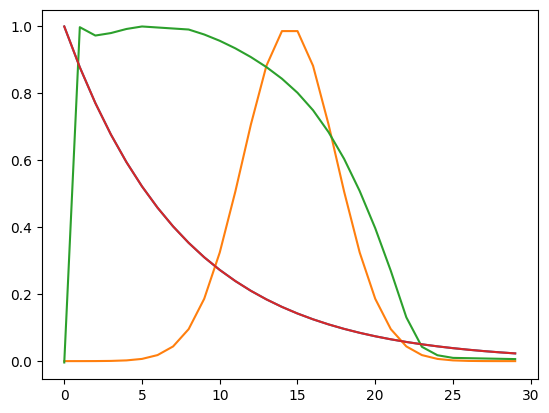

In [4]:
# Signal1: Gaussian
signal1 = signal.gaussian(30, std=3)

# Signal2: Cardiac Ventricular Action Potential
AP_original = np.loadtxt(r"C:\Users\mazo260d\Documents\GitHub\metroid\Simulated_Data\AP.txt",delimiter='\t')
time_sub = np.linspace(0, 5, n_samples) #time vector

# Re-sample at a constant sampling frequency
AP_original[:,0] = AP_original[:,0]/1000                       #ms to sec
xvals = np.arange(AP_original[0,0], AP_original[-1,0], 0.0001) #generate a time vetor with a constant sampling frequency
yinterp = np.interp(xvals, AP_original[:,0], AP_original[:,1]) #interpolate values where original AP time data is missing

# Re-sample by number of samples
yinterp1 = np.interp(time_sub, xvals, yinterp)   #interpolate (extend) data to whole time vector
# Normalize
signal2 = yinterp1
signal2 = signal2+abs(signal2[-1])                          #shift amp from ~-80 to 0
signal2 = signal2/np.amax(signal2)                          #normalize amplitude
# Crop
signal2 = signal2[:30]

# Signal3: Decreasing Monoexponential
def monoexp(x, a, b):
    return a * np.exp(-b * x)
b=0.13
a=1
x = np.arange(30)
signal3 = monoexp(x, a, b)

signals_dict = {0: signal1,
                1: signal2,
                2: signal3}

plt.plot(signal1)
plt.plot(signal2)
plt.plot(signal3)

In [47]:
def generate_random_signal_composition(signals_dict, n_samples=500, min_gap=5, max_gap=100):
    composite_signal = np.zeros(n_samples)
    
    position = 0
    while position < n_samples:
        start = position
        # width = np.random.randint(min_width, max(min(max_width, n_samples - position), min_width + 1) + 1)
        signal = signals_dict[np.random.randint(low=0, high=len(signals_dict))]
        width = min(len(signal), n_samples - position)
        composite_signal[start:start+width] = signal[:width]
        position += width + np.random.randint(min_gap, max_gap)  # Move to the end of that window and add some space

    return composite_signal

In [48]:
composite_signal = generate_random_signal_composition(signals_dict=signals_dict)

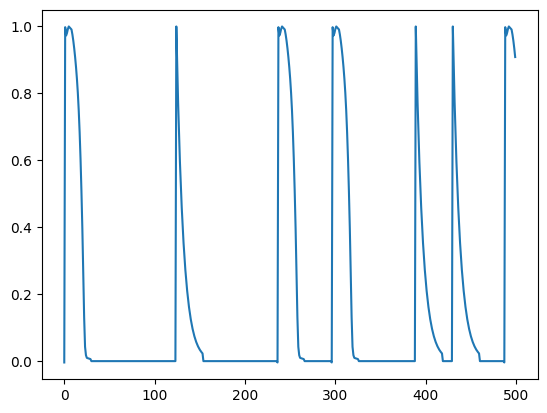

In [49]:
plt.plot(composite_signal)

## Generate random objects

In [45]:
# Generate objects

disk = morphology.disk(4)
square = morphology.square(9)
square[square == 1] = 2
diamond = morphology.diamond(4)
diamond[diamond == 1] = 3
objects_list = [disk, square, diamond]
image = np.zeros((100, 100))
object_order = []
for i in range(10):
    for j in range(3):
        n = np.random.randint(low=2, high=5)
        # obj = objects_list[n]
        obj = morphology.disk(n)
        image[i * 10: i * 10 + (n*2 + 1), 20 + j * 20: 20 + j * 20 + (n*2 + 1)] = obj
        object_order.append(n)

## Add composite signals to objects

In [50]:
# Add signals to label image

label_image = label(image)
height, width = image.shape
time_points = n_samples
time_lapse = np.zeros((time_points, height, width))
for i in range(label_image.max()):
    # print(object_order[i])
    # for label in [1, 2, 3]:
    mask = (label_image == i + 1)  # create boolean mask for current label
    # current_signal = signals[object_order[i]]  # get corresponding signal for current label
    current_signal = generate_random_signal_composition(signals_dict)

    # Add random phase by shifting signal
    random_shift = np.random.random()
    current_signal = np.roll(current_signal, int(random_shift * len(current_signal)))

    
    # Add random offset
    current_signal = current_signal + np.random.random() * 5

    # # Add random window pulses
    # random_windows = generate_random_window_mask()
    # current_signal[~random_windows] = 0

    # Add random noise
    current_signal = current_signal + np.random.random(size=len(current_signal)) / 10

    time_lapse[:, mask] = current_signal.reshape((time_points, -1))  # assign signal to region corresponding to current label

## Add intensities to a table

In [51]:
df = pd.DataFrame([])
for i in range(time_points):
    features = regionprops_table(label_image, intensity_image=time_lapse[i], properties=('label', 'mean_intensity'))
    features['frame'] = i
    # data = features.values()
    df = pd.concat([df, pd.DataFrame(features)])

## Add data to napari

In [53]:
viewer = napari.Viewer()
averages = np.mean(time_lapse, axis=(1, 2))
viewer.add_image(time_lapse, name='time-lapse')
table = df

viewer.add_labels(label_image, features=table, name='labels')

<Labels layer 'labels' at 0x247d51be760>

## Annotate some signals

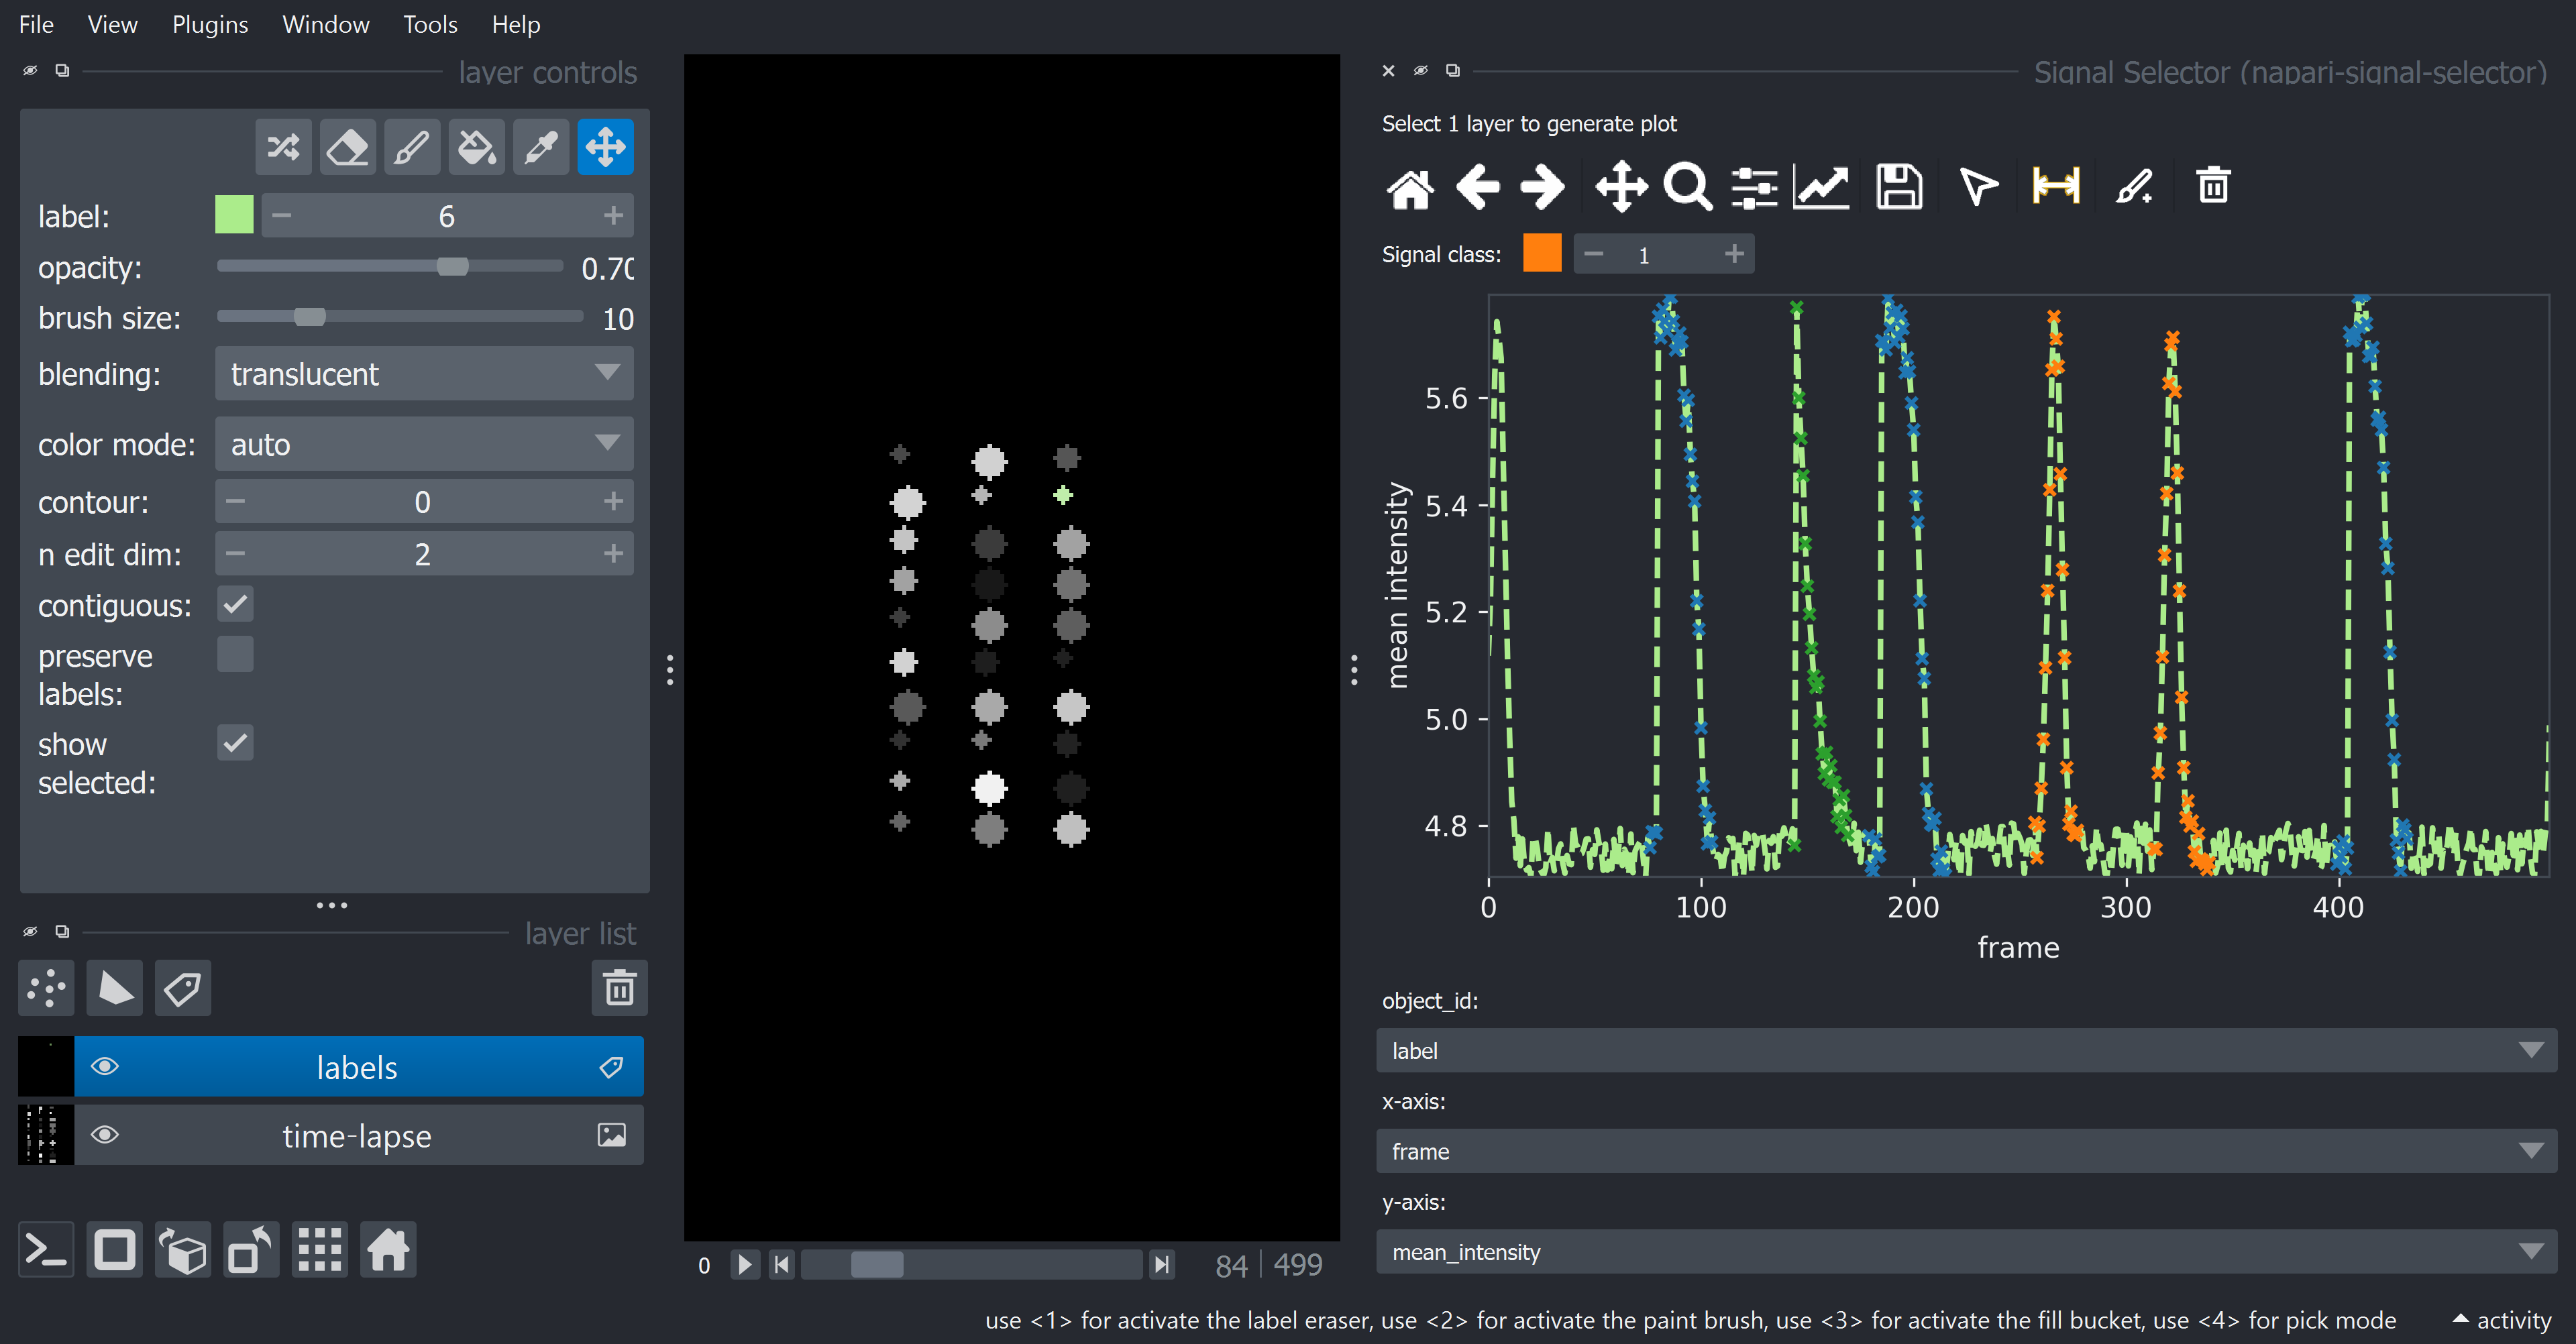

In [55]:
nbscreenshot(viewer)

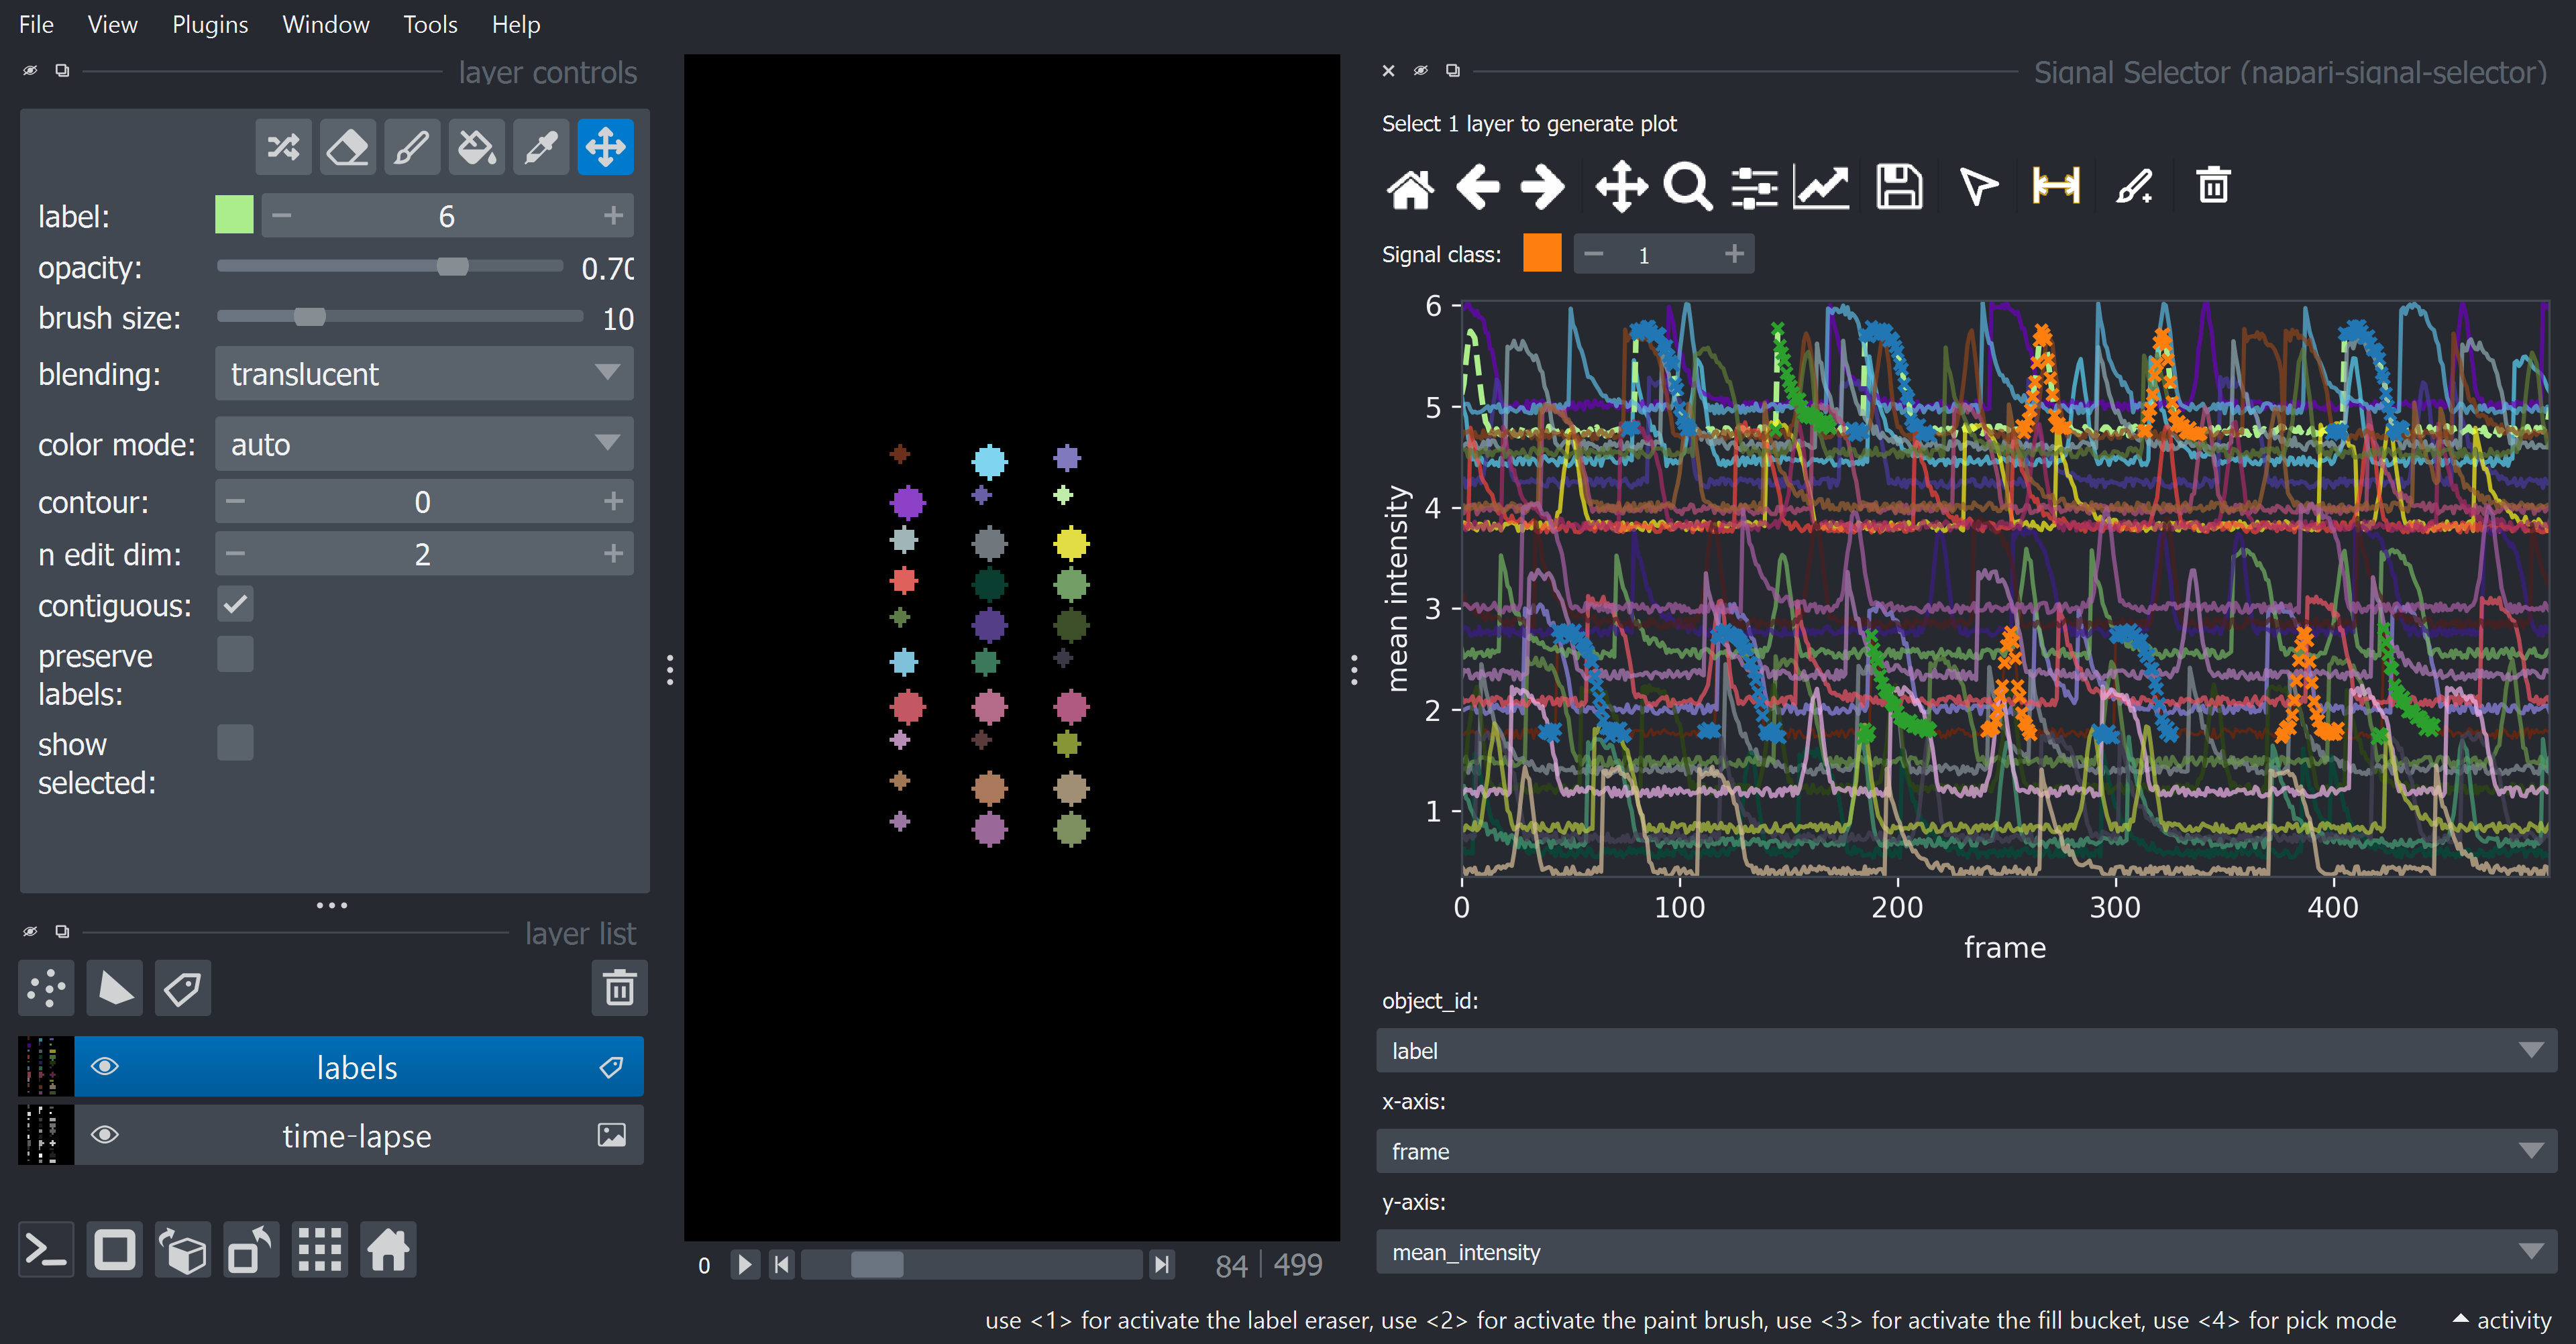

In [56]:
nbscreenshot(viewer)

## Save table with annotations to disk

In [57]:
table = viewer.layers[-1].features
table

label  mean_intensity  frame  Annotations
0          1        1.762031      0            0
1          2        5.108557      0            0
2          3        2.005329      0            0
3          4        5.965980      0            0
4          5        4.262265      0            0
...      ...             ...    ...          ...
14995     26        4.684677    499            0
14996     27        0.353091    499            0
14997     28        2.366432    499            0
14998     29        2.976129    499            0
14999     30        4.589720    499            0

[15000 rows x 4 columns]

In [59]:
# table.to_csv('table_with_annotations.csv')

table = pd.read_csv('table_with_annotations.csv')
table

Unnamed: 0  label  mean_intensity  frame  Annotations
0               0      1        1.762031      0            0
1               1      2        5.108557      0            0
2               2      3        2.005329      0            0
3               3      4        5.965980      0            0
4               4      5        4.262265      0            0
...           ...    ...             ...    ...          ...
14995       14995     26        4.684677    499            0
14996       14996     27        0.353091    499            0
14997       14997     28        2.366432    499            0
14998       14998     29        2.976129    499            0
14999       14999     30        4.589720    499            0

[15000 rows x 5 columns]

## Get training data

In [186]:
table_training = table[(table['label'] == 1) | (table['label'] == 6)].sort_values(by=['label', 'frame']).reset_index(drop=True)
table_training

Unnamed: 0  label  mean_intensity  frame  Annotations
0             0      1        1.762031      0            0
1            30      1        1.750145      1            0
2            60      1        1.779517      2            0
3            90      1        1.762593      3            0
4           120      1        1.773054      4            0
..          ...    ...             ...    ...          ...
995       14855      6        4.789773    495            0
996       14885      6        4.747110    496            0
997       14915      6        4.784049    497            0
998       14945      6        4.804249    498            0
999       14975      6        4.988024    499            0

[1000 rows x 5 columns]

In [187]:
data = table_training['mean_intensity'].values
annotations = table_training['Annotations'].values

# OR (smaller sample)

# # Sample data
# data = np.array([0, 1, 2, 0, 0, 3, 4, 5, 0, 6, 0, 1, 2, 0, 0, 0, 6, 0])
# annotations = np.array([0, 1, 1, 0, 0, 2, 2, 2, 0, 3, 0, 1, 1, 0, 0, 0, 3, 0])

Functions to extract annotated signal parts

In [182]:
def extract_signal_regions(data, annotations):
    # Use a dictionary to store signals by class
    signals_by_class = {}
    
    # Initialize variables for currently observed signal and its starting index
    current_signal = 0
    start_index = None
    
    for i, ann in enumerate(annotations):
        if ann > 0:  # Signal detected
            if current_signal == 0:  # New signal starts
                current_signal = ann
                start_index = i
            elif current_signal != ann:  # Different signal detected
                # Store the previous signal
                if current_signal not in signals_by_class:
                    signals_by_class[current_signal] = []
                signals_by_class[current_signal].append(data[start_index:i])
                
                # Start tracking the new signal
                current_signal = ann
                start_index = i
        else:  # Noise detected
            if current_signal > 0:  # Previous signal ends
                # Store the signal
                if current_signal not in signals_by_class:
                    signals_by_class[current_signal] = []
                signals_by_class[current_signal].append(data[start_index:i])
                
                # Reset tracking variables
                current_signal = 0
                start_index = None
    
    # Handle the case where the last signal goes until the end of the array
    if current_signal > 0:
        if current_signal not in signals_by_class:
            signals_by_class[current_signal] = []
        signals_by_class[current_signal].append(data[start_index:])
    
    return signals_by_class




In [183]:
def extract_signal_regions2(data, annotations):
    signals_by_class = {}
    # Split annotations in lists
    annotation_indices_list = [np.ravel((annotations == i).nonzero()) for i in range(1, max(annotations)+1)]
    for signal_class, annotation_indices in enumerate(annotation_indices_list):
        # Get a mask where transitions occur in annotations
        indices_transition_mask = np.diff(annotation_indices, prepend=0) > 1
        # Get maks indices where transitions occur
        transition_indices = np.flatnonzero(indices_transition_mask)
        transition_indices = transition_indices.tolist()
        # Insert first and last indices
        if transition_indices[0] != 0:
            transition_indices.insert(0,0)
        transition_indices.append(len(annotation_indices))
        # Store all annotated signal parts to the corresponding class
        for start, end in zip(transition_indices[:-1], transition_indices[1:]):
            if signal_class+1 not in signals_by_class:
                signals_by_class[signal_class+1] = []
            signals_by_class[signal_class+1].append(data[annotation_indices[start: end]])
    return signals_by_class

Benchmark functions

In [184]:
%%timeit
# Test the function
result = extract_signal_regions(data, annotations)
result

124 µs ± 9.12 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [185]:
%%timeit
# Test the function
result2 = extract_signal_regions2(data, annotations)
result2

147 µs ± 7.71 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [188]:
signals_by_class = extract_signal_regions2(data, annotations)
signals_by_class

{1: [array([1.78890312, 1.80181083, 1.83157021, 1.818891  , 1.89095378,
         1.99716972, 2.13372776, 2.23507812, 2.46192183, 2.62953023,
         2.70953394, 2.76416552, 2.67072169, 2.50609541, 2.23324763,
         2.1269312 , 1.96519734, 1.88066338, 1.84963366, 1.79517346,
         1.75486592]),
  array([1.72835001, 1.7634556 , 1.81223152, 1.83307771, 1.81575703,
         1.94641915, 2.09153025, 2.2854246 , 2.48629933, 2.63360095,
         2.75690916, 2.74894763, 2.68563106, 2.47430911, 2.26507315,
         2.07973533, 1.95814756, 1.89066646, 1.8124114 , 1.79886285,
         1.79506491, 1.76883862, 1.75796041, 1.80247072, 1.756425  ,
         1.76083706, 1.81366845]),
  array([4.80641827, 4.74040278, 4.79957694, 4.87032691, 4.96158811,
         5.09512043, 5.2394685 , 5.427873  , 5.651695  , 5.75174139,
         5.70974678, 5.65861488, 5.45776954, 5.27871574, 5.11399324,
         4.90884737, 4.80315299, 4.82745125, 4.78463682, 4.78221303,
         4.79160705]),
  array([4.75719498

Get one sub-signal as a test

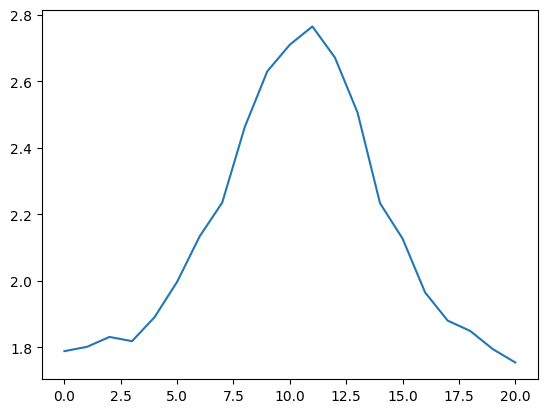

In [192]:
sub_signal1 = signals_by_class[1][0]
plt.plot(sub_signal1)

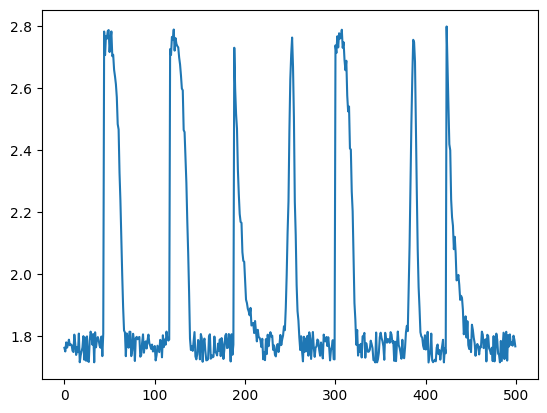

In [193]:
composite_signal1 = table[(table['label'] == 1)].sort_values(by=['label', 'frame']).reset_index(drop=True)['mean_intensity'].values
plt.plot(composite_signal1)

Calculate cross-correlation with whole annotated composite signal and plot result

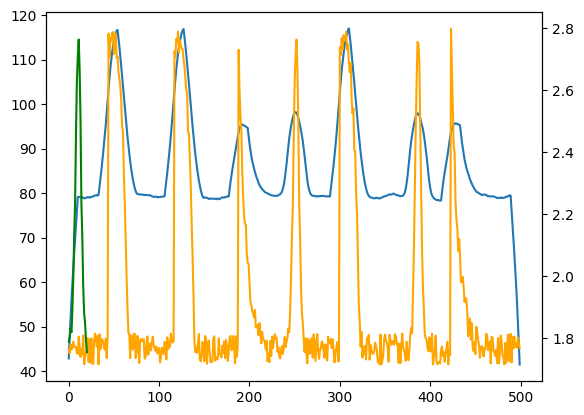

In [197]:
fig, ax = plt.subplots()
cross_corr_result = signal.correlate(composite_signal1, sub_signal1, mode='same')
ax.plot(cross_corr_result)
ax2 = ax.twinx()
ax2.plot(composite_signal1, color='orange')
ax2.plot(sub_signal1, color='green')

In [60]:
# Get training data
# table_training = table[table['Annotations'] > 0]
# Reshape table, storing one signal per row
signals_table_training = table_training.pivot(
    index='label',
    columns='frame',
    values='mean_intensity')

- get signals with annotations (DONE, currently filtering by specific label ID (to get noise parts as well))
  - get short-signals separated by class (DONE in `signal_by_class`)

  - calculate cross-correlations with composite signal(s) (DONE with one example above)

- caculate wavelets for short-signals

  - calculate cross-correlations of each short-signal decomposition level with corresponding decomposition level of composite signal(s)


- consider thrsholding or features to find potential matches
